In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [4]:
batch_size = 32
img_height = 224
img_width = 224

In [5]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,shear_range=0.15,validation_split=0.25)
test_datagen = ImageDataGenerator()

Train_Image = train_datagen.flow_from_directory(train_path, target_size=(img_height, img_width),
                                                     class_mode="categorical", batch_size=batch_size, subset="training")


Val_Image = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Test_Image = test_datagen.flow_from_directory(test_path, target_size=(img_height, img_width),
                                                    class_mode="categorical", batch_size=batch_size, shuffle=False)

Found 3560 images belonging to 4 classes.
Found 1186 images belonging to 4 classes.
Found 1186 images belonging to 4 classes.


In [6]:
train_class = Train_Image.num_classes
train_class

4

In [7]:
test_class = Test_Image.num_classes
test_class

4

In [8]:
xception = Xception(weights='imagenet', include_top = False, input_shape = (224,224,3))

83683744/83683744 [==============================] - 80s 1us/step


In [9]:
for i in xception.layers:
    i.trainable = False

In [10]:
def main_model(tl_model,class1):
    m_model = tl_model.output
    m_model = GlobalAveragePooling2D()(m_model)
    m_model = Dense(1024,activation='relu')(m_model)
    m_model = Dense(1024,activation='relu')(m_model)
    m_model = Dense(512,activation='relu')(m_model)
    m_model = Dense(class1,activation = 'softmax')(m_model)
    return m_model


In [11]:
combining_model = main_model(xception,train_class)

In [12]:
model = Model(inputs=xception.input, outputs=combining_model)

In [13]:
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [15]:
history = model.fit(Train_Image, steps_per_epoch = int(3560/batch_size), validation_data=Val_Image,validation_steps=int(1186/batch_size),epochs=40)

Epoch 1/40
111/111 [==============================] - 527s 5s/step - loss: 1.3501 - accuracy: 0.6480 - val_loss: 0.7244 - val_accuracy: 0.7213
Epoch 2/40
111/111 [==============================] - 512s 5s/step - loss: 0.6402 - accuracy: 0.7423 - val_loss: 0.6268 - val_accuracy: 0.7568
Epoch 3/40
111/111 [==============================] - 484s 4s/step - loss: 0.5633 - accuracy: 0.7786 - val_loss: 0.5276 - val_accuracy: 0.7880
Epoch 4/40
111/111 [==============================] - 297s 3s/step - loss: 0.5185 - accuracy: 0.7846 - val_loss: 0.5736 - val_accuracy: 0.7593
Epoch 5/40
111/111 [==============================] - 675s 6s/step - loss: 0.4846 - accuracy: 0.8090 - val_loss: 0.6603 - val_accuracy: 0.7407
Epoch 6/40
111/111 [==============================] - 715s 6s/step - loss: 0.4316 - accuracy: 0.8254 - val_loss: 0.4686 - val_accuracy: 0.8142
Epoch 7/40
111/111 [==============================] - 717s 6s/step - loss: 0.3969 - accuracy: 0.8461 - val_loss: 0.5555 - val_accuracy: 0.7973

In [16]:
model.save("paddy_xceptionnet40_new.h5")

In [17]:
Test_score = model.evaluate(Test_Image,steps = len(Test_Image))
Test_score

38/38 [==============================] - 131s 3s/step - loss: 0.4237 - accuracy: 0.8727


[0.4237312078475952, 0.8726812601089478]

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools 


target_names = []
for key in Train_Image.class_indices:
    target_names.append(key)

In [19]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

38/38 [==============================] - 137s 4s/step
Confusion Matrix
Confusion matrix, without normalization


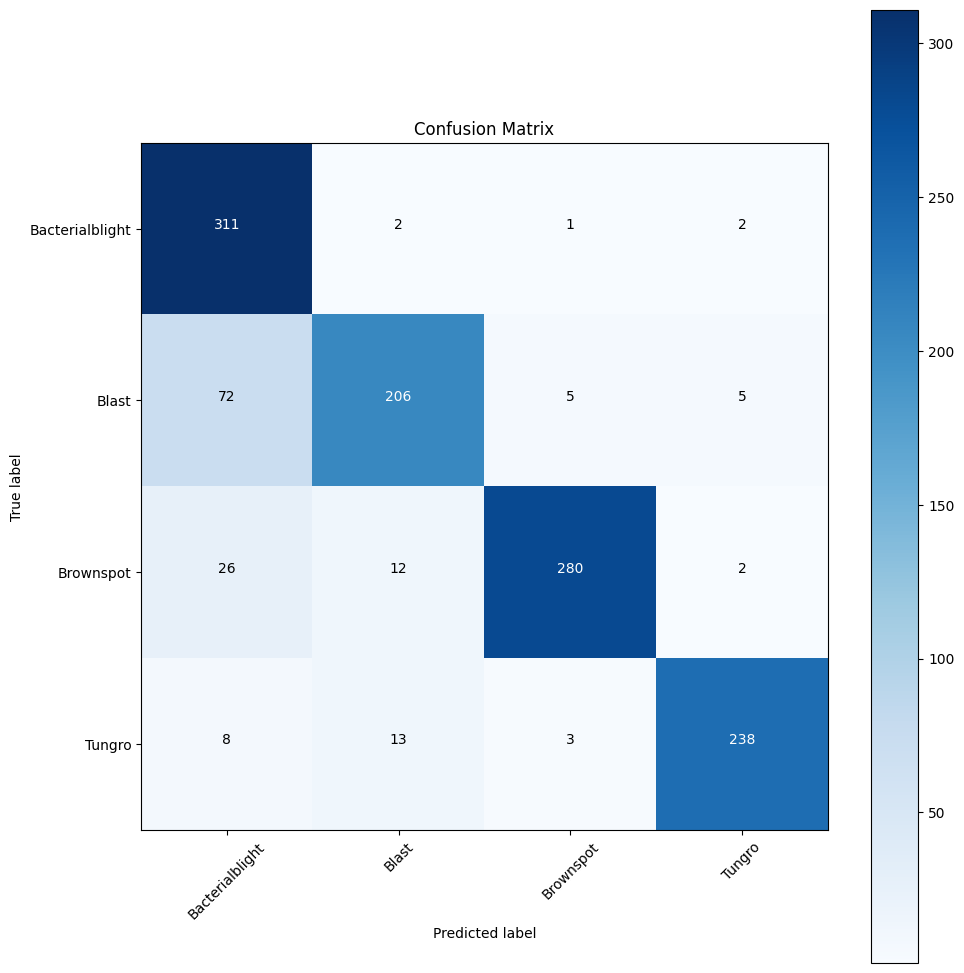

In [20]:
#Confution Matrix and Classification Report
Y_pred_Model = model.predict(Test_Image)
Y_pred_Model = np.argmax(Y_pred_Model, axis=-1)
print('Confusion Matrix') 
CM_Model=confusion_matrix(Test_Image.classes, Y_pred_Model)

plot_confusion_matrix(CM_Model, target_names, title='Confusion Matrix')


In [21]:
print('Classification Report')
print(classification_report(Test_Image.classes, Y_pred_Model, target_names=target_names))

Classification Report
                 precision    recall  f1-score   support

Bacterialblight       0.75      0.98      0.85       316
          Blast       0.88      0.72      0.79       288
      Brownspot       0.97      0.88      0.92       320
         Tungro       0.96      0.91      0.94       262

       accuracy                           0.87      1186
      macro avg       0.89      0.87      0.87      1186
   weighted avg       0.89      0.87      0.87      1186



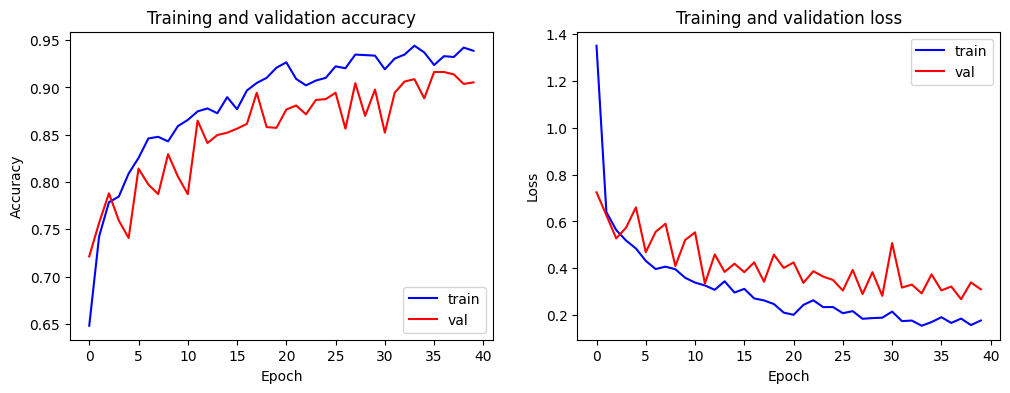

In [22]:
Train_accuracy = history.history['accuracy']
Val_accuracy = history.history['val_accuracy']
Train_loss = history.history['loss']
Val_loss = history.history['val_loss']

epochs = range(len(Train_accuracy))
plt.figure(figsize=(12,4))

# Plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs, Train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, Val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')

# Plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs, Train_loss, 'b', label='Training loss')
plt.plot(epochs, Val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

In [23]:
labels = Train_Image.class_indices
final_labels = {v: k for k, v in labels.items()}
final_labels

{0: 'Bacterialblight', 1: 'Blast', 2: 'Brownspot', 3: 'Tungro'}

In [ ]:
from tensorflow.keras.models import load_model
import ast
from tensorflow.keras.preprocessing import image

In [ ]:
def predict_image(imgname, from_test_dir):
    test_image = image.load_img(imgname, target_size = (224, 224))

    plt.imshow(test_image)
    plt.show()

    test_image = np.asarray(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    result = model.predict(test_image)

    result_dict = dict()
    for key in list(final_labels.keys()):
        result_dict[final_labels[key]] = result[0][key]
    sorted_results = {k: v for k, v in sorted(result_dict.items(), key=lambda item: item[1], reverse=True)}

    if not from_test_dir:
        print('=' * 50)
        for label in sorted_results.keys():
            print("{}: {}%".format(label, sorted_results[label] * 100))

    final_result = dict()
    final_result[list(sorted_results.keys())[0]] = sorted_results[list(sorted_results.keys())[0]] * 100

    return final_result


